In [1]:
# simulation rewrite
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sourcesep.utils.compute import lowpass
import matplotlib as mpl

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'

from sourcesep.sim import SimData
from sourcesep.utils.config import load_config
from sourcesep.utils.compute import custom_sigmoid, softplus

paths = load_config(dataset_key="all")
sim = SimData(n_samples=72000, cfg_path=paths["root"] / "sim_config.toml")

Paths are for dataset tagged: all
Paths are for dataset tagged: all


In [2]:
T = 1000
sampling_freq_Hz = 20
n_samples = T * sampling_freq_Hz
spiking_freq_Hz = 0.2
sampling_interval = 1 / sampling_freq_Hz
lowpass_thr_Hz = 0.2
decay_const_s = 0.2
rng = np.random.default_rng()
slow_dyn_bottom = 0.0
slow_dyn_top = 0.2
slow_dyn_beta = 1.0

T_arr = np.arange(0, T, sampling_interval)

A_fast = sim._dyn_fast(
    n_samples=n_samples,
    spiking_freq_Hz=spiking_freq_Hz,
    sampling_interval=sampling_interval,
    decay_const_s=decay_const_s,
    rng=rng,
)

A_slow = sim._dyn_slow(
    n_samples=n_samples,
    sampling_interval=sampling_interval,
    lowpass_thr_Hz=lowpass_thr_Hz,
    bottom=slow_dyn_bottom,
    top=slow_dyn_top,
    beta=slow_dyn_beta,
    rng=rng,
)

0.10030063363375445 0.0017643425185176582


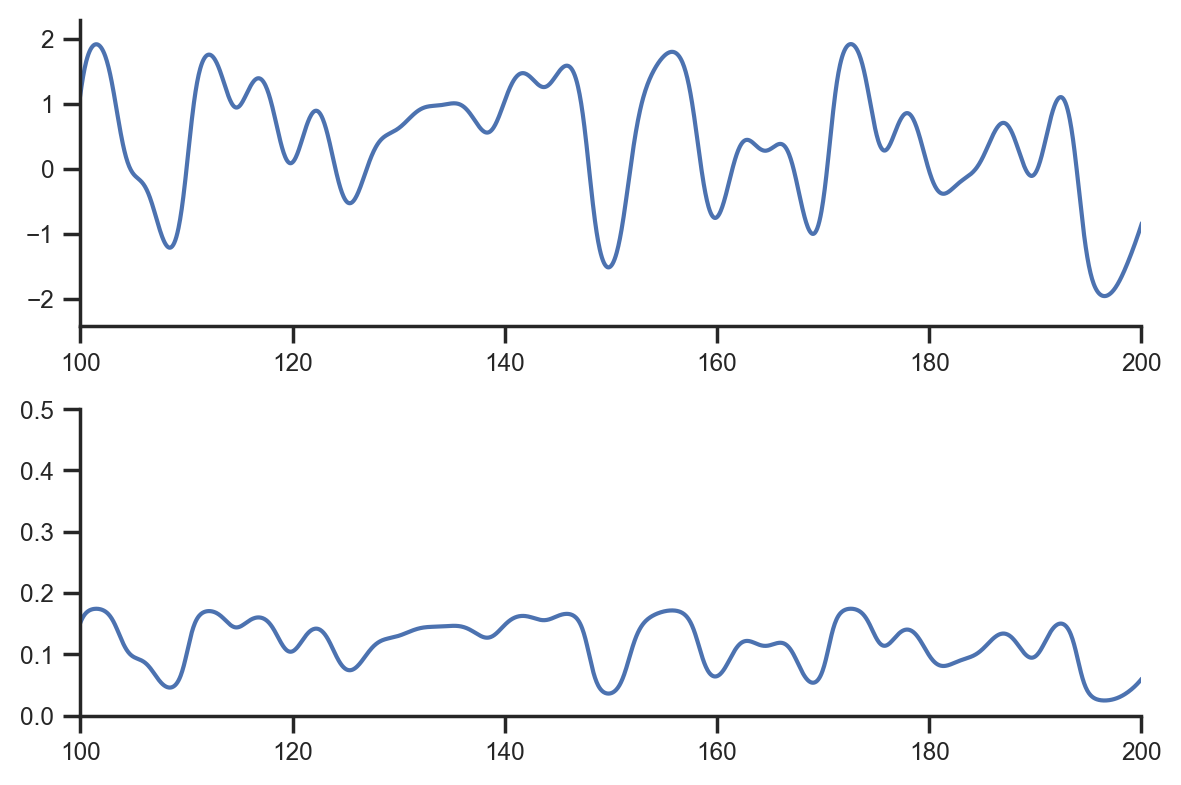

In [3]:
print(np.mean(A_slow), np.var(A_slow))
A_slow = A_slow - np.mean(A_slow)
A_slow = A_slow / np.std(A_slow)

f, ax = plt.subplots(2, 1, figsize=(6, 4))
ax[0].plot(T_arr, A_slow)
ax[1].plot(T_arr, custom_sigmoid(A_slow, bottom=0, top=0.2, beta=1))
ax[0].set(xlim=(100, 200))
ax[1].set(xlim=(100, 200), ylim=(0, 0.5))
plt.tight_layout()
plt.show()

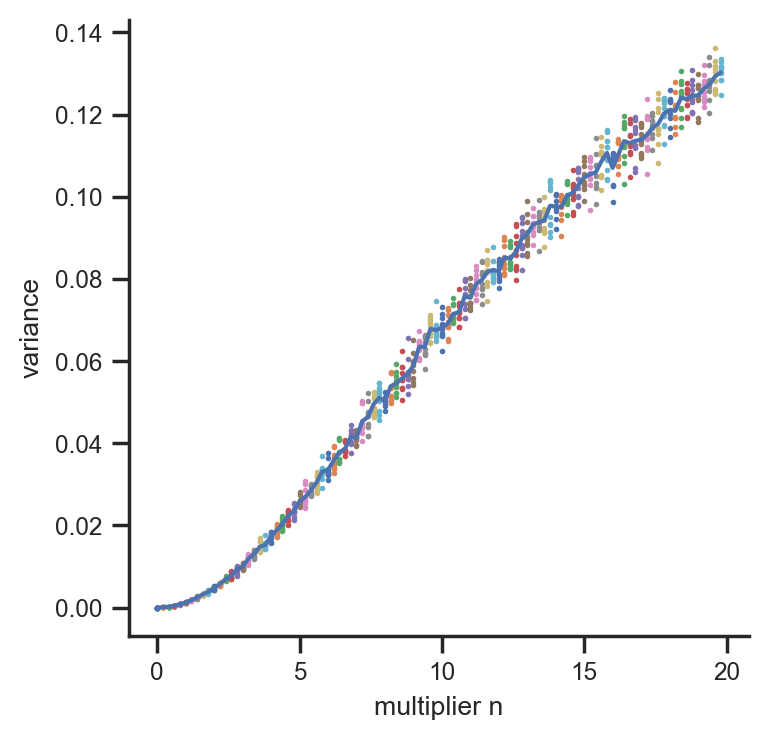

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


n_range = np.arange(0, 20, 0.2)
var_ = []
f, ax = plt.subplots(1, 1, figsize=(4, 4))
for n in n_range:
    var_list = []
    for i in range(10):
        A_slow = lowpass(
            xt=rng.standard_normal(size=(n_samples,)),
            sampling_interval=sampling_interval,
            pass_below=lowpass_thr_Hz,
            axis=0,
        )

        var_list.append(np.var(sigmoid(n * A_slow)))
    ax.scatter([n] * len(var_list), var_list, s=1)
    var_.append(np.mean(var_list))
ax.plot(n_range, var_)
ax.set(xlabel="multiplier n", ylabel="variance")
plt.show()

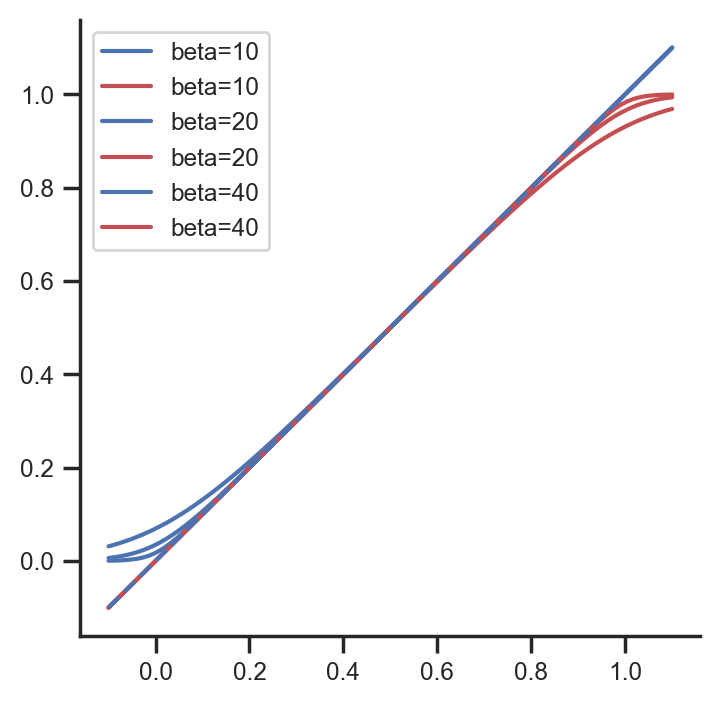

In [5]:
x = np.linspace(-0.1, 1.1, 100)

f, ax = plt.subplots(1, 1, figsize=(4, 4))
for beta in [10, 20, 40]:
    ax.plot(x, softplus(x, beta=beta, thr=10), label=f"beta={beta}", c="b")
    ax.plot(x, 1 - softplus(1 - x, beta=beta, thr=10), label=f"beta={beta}", c="r")
ax.plot(x, x, "--")
ax.legend()
plt.show()

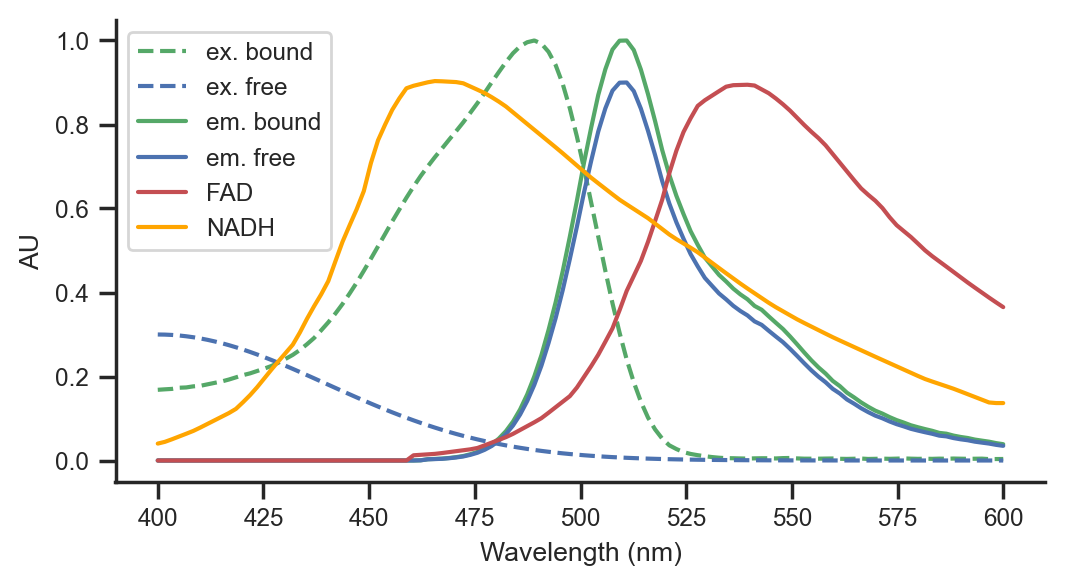

In [6]:
S = sim.get_S_synthetic()
S_autofl = sim.get_S_autofl()

f, ax = plt.subplots(figsize=(6, 3))
ax.plot(sim.L_arr, S["bound_ex"], "--g", label="ex. bound")
ax.plot(sim.L_arr, S["free_ex"], "--b", label="ex. free")
ax.plot(sim.L_arr, S["bound_em"], "g", label="em. bound")
ax.plot(sim.L_arr, 0.9 * S["free_em"], "b", label="em. free")
ax.plot(sim.L_arr, S_autofl[0, :], c="r", label="FAD")
ax.plot(sim.L_arr, S_autofl[1, :], c="orange", label="NADH")
ax.set(xlabel="Wavelength (nm)", ylabel="AU")
plt.legend()
plt.show()

In [7]:
lam_ = [sim.cfg["laser"][key]["em_wavelength_nm"] for key in sim.cfg["laser"].keys()]

In [8]:
lam_ = [sim.cfg["laser"][key]["em_wavelength_nm"] for key in sim.cfg["laser"].keys()]

# W is related to choice of laser. There are two lasers
Wb = np.zeros((1, sim.J))
Wf = np.zeros((1, sim.J))
for j in range(sim.J):
    Wb[0, j] = S["bound_ex"][sim.get_L_ind([lam_[j]])]
    Wf[0, j] = S["free_ex"][sim.get_L_ind([lam_[j]])]

# assume that bound and free states have the same spectrum
Sb = S["bound_em"].reshape(1, -1)
Sf = S["free_em"].reshape(1, -1)

# simulate bound fraction of indicator
fb = sim.gen_f_bound_slow() + sim.gen_f_bound_fast()
fb = 1.0 - softplus(1.0 - fb, beta=40, thr=1.0)  # ensures fb in range [0,1]

f_rest = 0.3
f_dynamic_range = 0.2 * f_rest
fb = f_rest + fb * f_dynamic_range

ff = 1.0 - fb  # free fraction

# simlulate laser, for two lasers
P = sim.gen_P()

In [9]:
f_dynamic_range

0.06

In [10]:
print(fb.shape)
print(Sb.shape)
print(Wb.shape)
print(P.shape)

(72000, 1)
(1, 120)
(1, 5)
(72000, 5)


In [11]:
# Get contribution of bound and free states to the observed signal
fSW_ = np.einsum("ti,il,ij->tjl", fb, Sb, Wb)
fSWP_b = np.einsum("tjl,tj->tjl", fSW_, P)

fSW_ = np.einsum("ti,il,ij->tjl", ff, Sf, Wf)
fSWP_f = np.einsum("tjl,tj->tjl", fSW_, P)

# The bound and free components are added together
fSWP = fSWP_b + fSWP_f

In [12]:
# get true f_rest signal
F0SW_b = np.einsum("ti,il,ij->tjl", np.ones_like(fb) * f_rest, Sb, Wb)
F0SWP_b = np.einsum("tjl,tj->tjl", F0SW_b, P)
F0SW_f = np.einsum("ti,il,ij->tjl", (1.0 - np.ones_like(fb) * f_rest), Sf, Wf)
F0SWP_f = np.einsum("tjl,tj->tjl", F0SW_f, P)

F0SWP = F0SWP_b + F0SWP_f

In [13]:
fSWP.shape

(72000, 5, 120)

In [14]:
# plot utilities
def fmt_y_(x, _):
    if x < sim.L_arr.size:
        return f"{sim.L_arr[int(x)]:0.1f} nm"
    else:
        return "NA"


fmt_y = mpl.ticker.FuncFormatter(fmt_y_)


def fmt_x_(x, _):
    if x < sim.T_arr.size:
        return f"{sim.T_arr[int(x)]:0.1f} s"
    else:
        return "NA"


fmt_x = mpl.ticker.FuncFormatter(fmt_x_)

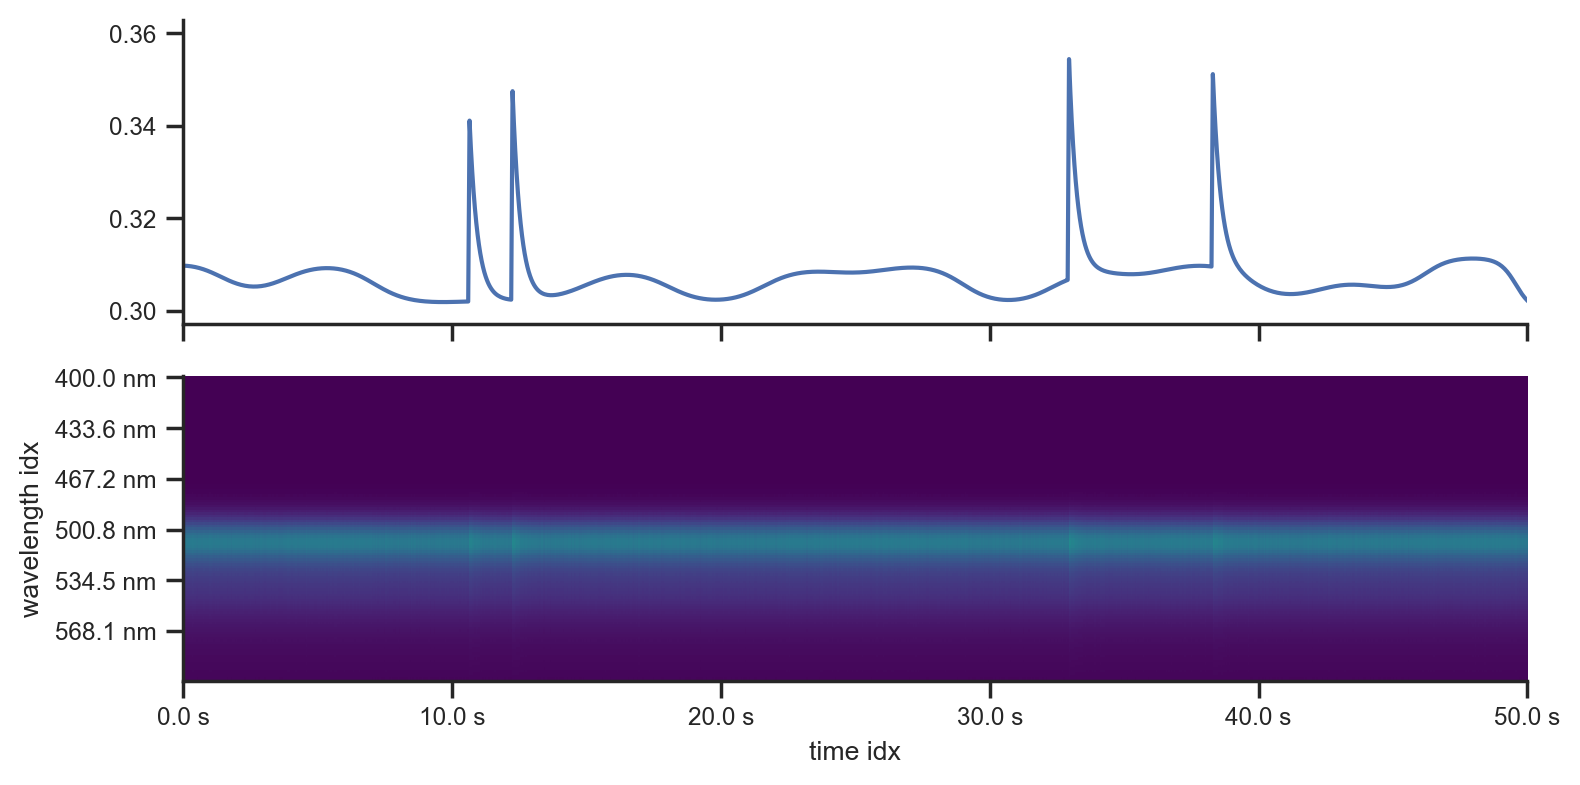

In [15]:
f, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax[0].plot(np.arange(0, fb.size), fb)
ax[1].imshow(fSWP_b[:, 1, :].T, aspect="auto", cmap="viridis", vmin=0.0, vmax=0.3, interpolation="nearest")
ax[1].xaxis.set(major_formatter=fmt_x)
ax[1].yaxis.set(major_formatter=fmt_y)
ax[1].set(xlim=(0, 1000), ylabel="wavelength idx", xlabel="time idx")
plt.tight_layout()
plt.show()

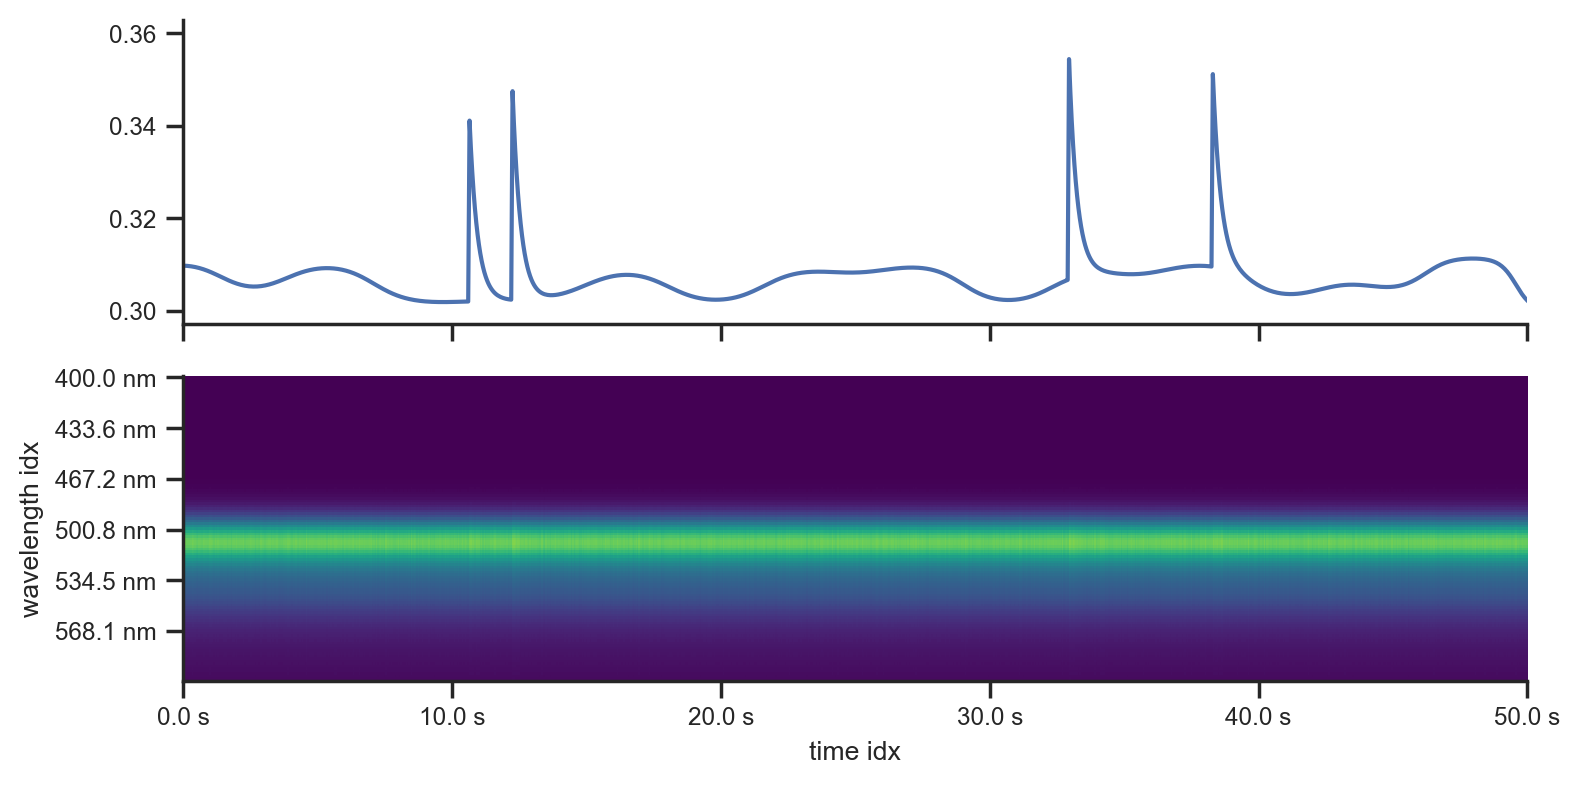

In [16]:
f, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax[0].plot(np.arange(0, fb.size), fb)
ax[1].imshow(fSWP[:, 1, :].T, aspect="auto", cmap="viridis", vmin=0.0, vmax=0.3, interpolation="nearest")
ax[1].xaxis.set(major_formatter=fmt_x)
ax[1].yaxis.set(major_formatter=fmt_y)
ax[1].set(xlim=(0, 1000), ylabel="wavelength idx", xlabel="time idx")
plt.tight_layout()
plt.show()

In [17]:
Wf

array([[2.97626136e-01, 1.57636190e-01, 5.86541914e-02, 5.06396524e-03,
        8.79280653e-05]])

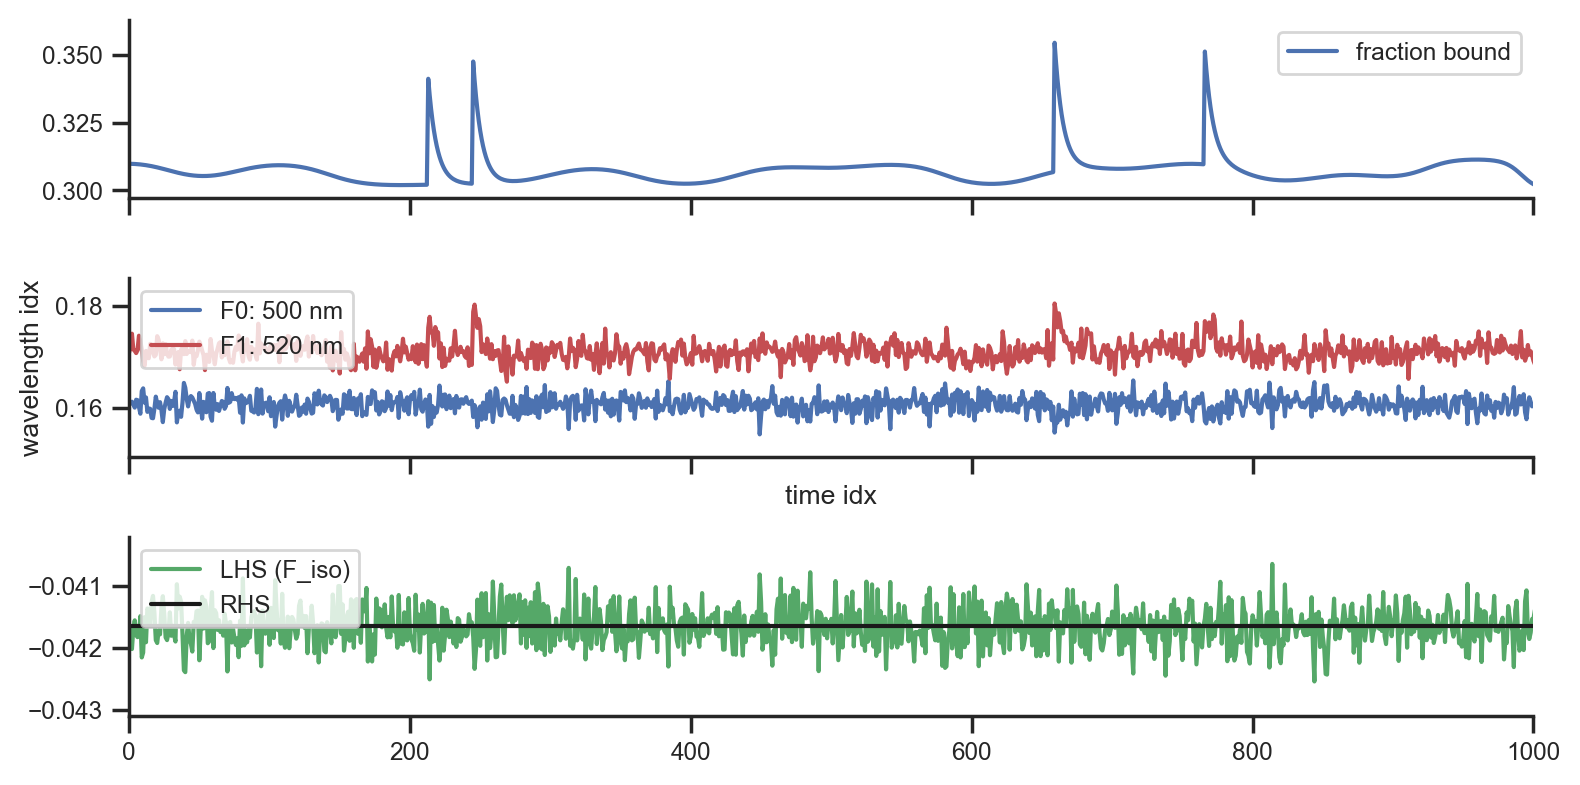

In [18]:
# testing linear combination to get isosbestic signal (Case I in documentation)

# The observation wavelengths:
lam_0 = 500
lam_1 = 520


def get_lind(lam):
    return np.argmin(np.abs(sim.L_arr - lam))


# observed signals at the two wavelengths
F0 = np.squeeze(fSWP[:, 0, get_lind(lam_0)])
F1 = np.squeeze(fSWP[:, 1, get_lind(lam_1)])

# constants to be used for the linear combination
m = Sf[0, get_lind(lam_1)] * np.mean(P[:, 1]) * (Wf[0, 1] - Wb[0, 1])
n = Sf[0, get_lind(lam_0)] * np.mean(P[:, 0]) * (Wb[0, 0] - Wf[0, 0])

# The signal independent of bound fraction
F_iso = m * F0 + n * F1

# get theoretical RHS
rhs = (
    Sf[0, get_lind(lam_0)]
    * np.mean(P[:, 0])
    * Sf[0, get_lind(lam_1)]
    * np.mean(P[:, 1])
    * (Wb[0, 0] * Wf[0, 1] - Wb[0, 1] * Wf[0, 0])
)

# plot lhs and rhs
f, ax = plt.subplots(3, 1, figsize=(8, 4), sharex=True)
ax[0].plot(np.arange(0, fb.size), fb, label="fraction bound")
ax[0].legend()

ax[1].plot(np.arange(0, fb.size), F0, "b", label=f"F0: {lam_0} nm")
ax[1].plot(np.arange(0, fb.size), F1, "r", label=f"F1: {lam_1} nm")
ax[1].legend()

ax[2].plot(np.arange(0, fb.size), F_iso, "g", label="LHS (F_iso)")
ax[2].plot([0, fb.size], [rhs, rhs], "k", label="RHS")

ax[1].set(xlim=(0, 1000), ylabel="wavelength idx", xlabel="time idx")
plt.legend()
plt.tight_layout()
plt.show()

# note that we used only avg. power to obtain the lhs, which is why it remains noisy.

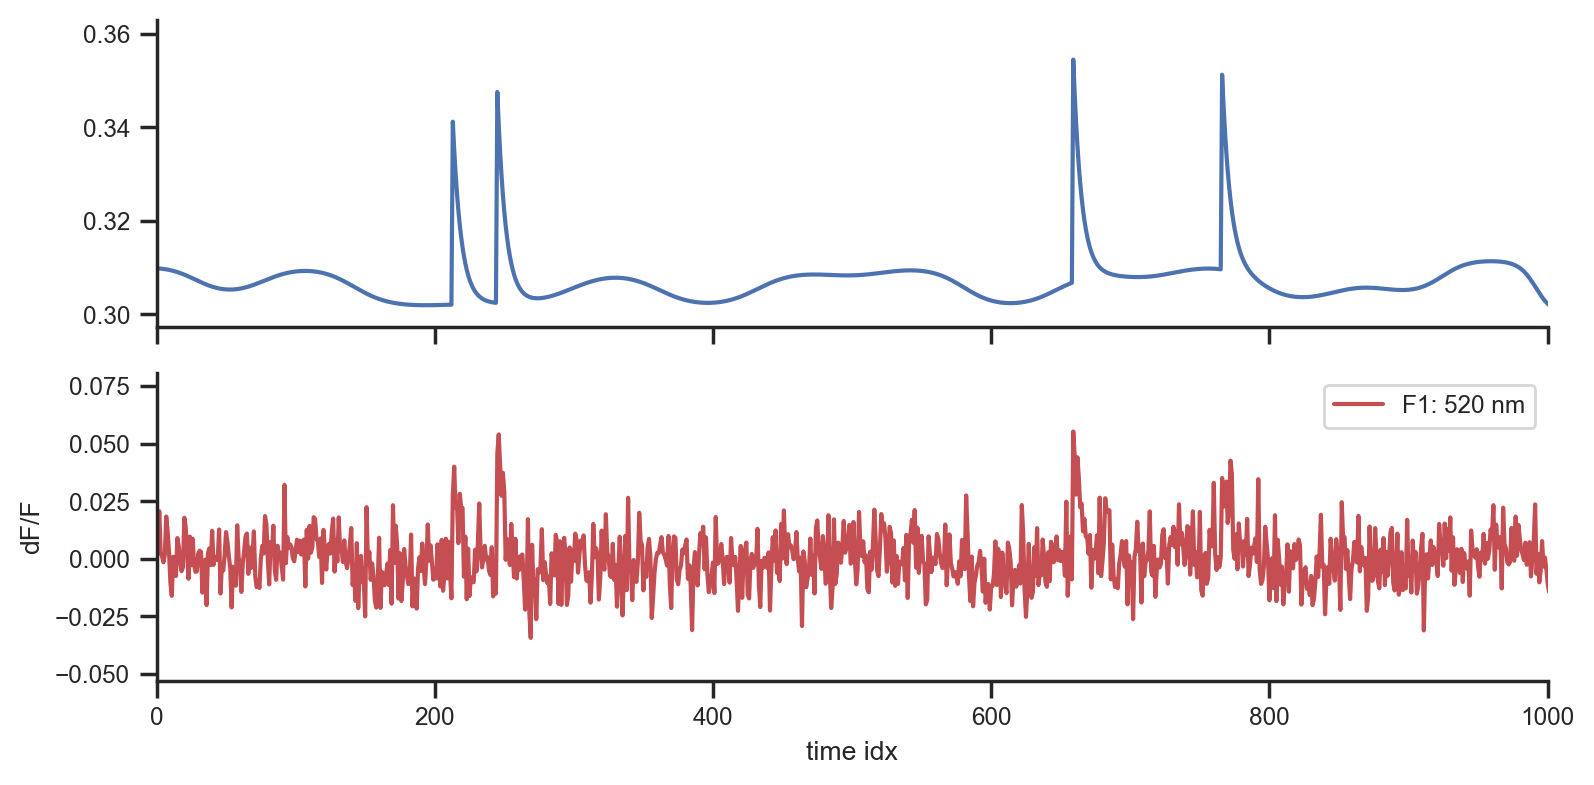

In [19]:
# naive df/f
f, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax[0].plot(np.arange(0, fb.size), fb)
ax[1].plot(np.arange(0, fb.size), (F1 - np.mean(F1)) / np.mean(F1), "r", label=f"F1: {lam_1} nm")
ax[1].set(xlim=(0, 1000), ylabel="dF/F", xlabel="time idx")
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
print(Wb[0, 0] * Wf[0, 1])
print(Wb[0, 1] * Wf[0, 0])

0.02730899081563283
0.11831537044965018


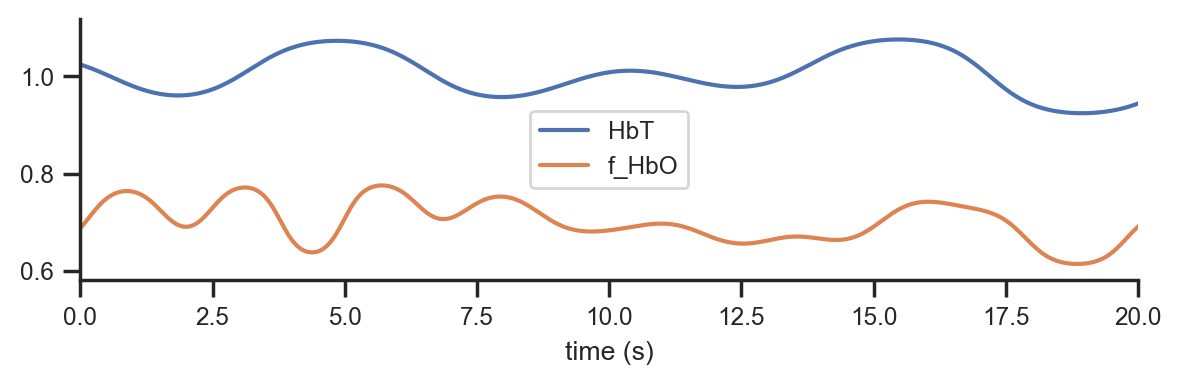

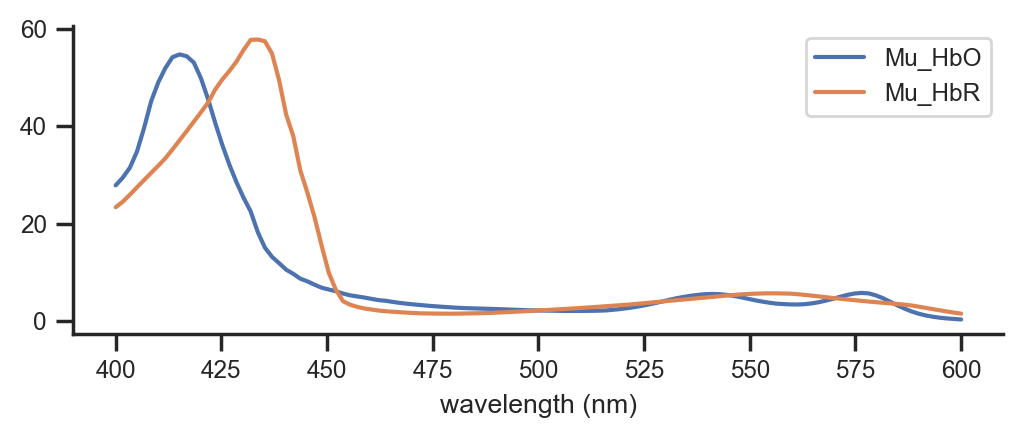

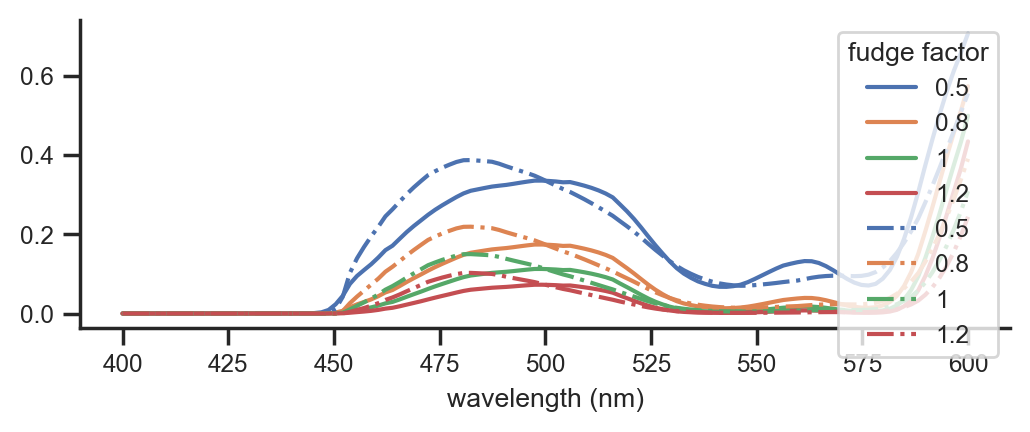

In [21]:
C_HbO, C_HbR, C_HbT, f_HbO = sim.gen_H()

# plot the HbO and HbR as time series
f, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(sim.T_arr, C_HbT, label="HbT")
ax.plot(sim.T_arr, f_HbO, label="f_HbO")
ax.set(xlim=(0, 20), xlabel="time (s)")
ax.legend()
plt.tight_layout()
plt.show()

Mu_HbO, Mu_HbR = sim.get_Mu()
# plot it against sim.L_arr
f, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(sim.L_arr, Mu_HbO, label="Mu_HbO")
ax.plot(sim.L_arr, Mu_HbR, label="Mu_HbR")
ax.set(xlabel="wavelength (nm)")
ax.legend()

h_HbO_av = 0.7
h_HbR_av = 0.3
f, ax = plt.subplots(1, 1, figsize=(6, 2))
for fudge in [0.5, 0.8, 1, 1.2]:
    ax.plot(sim.L_arr, np.exp(-fudge * (Mu_HbO * h_HbO_av + Mu_HbR * h_HbR_av)), label=fudge)

# reset color cycle
ax.set_prop_cycle(None)

h_HbO_av = 0.3
h_HbR_av = 0.7

for fudge in [0.5, 0.8, 1, 1.2]:
    ax.plot(sim.L_arr, np.exp(-fudge * (Mu_HbO * h_HbO_av + Mu_HbR * h_HbR_av)), linestyle="-.", label=fudge)


ax.set(xlabel="wavelength (nm)")
ax.legend(title="fudge factor")

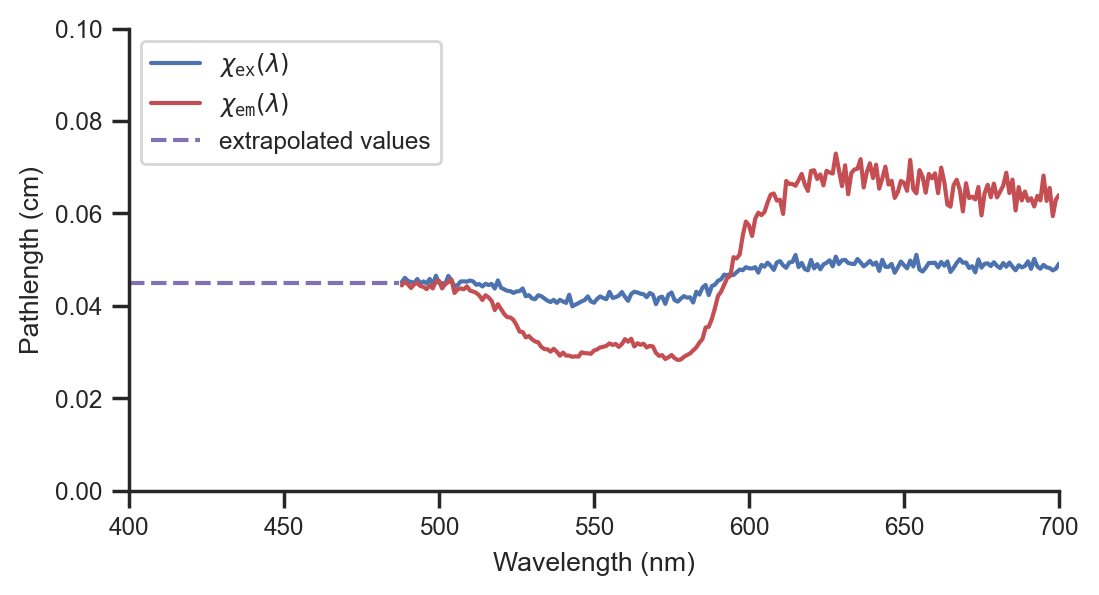

In [22]:
# pathlength obtained from simulations in Zhang et al. 2022.
# ex corresponds to path for light from an excitation laser inwards into the tissue
# em corresponds to path for light from emission outwards from the tissue

df = pd.read_csv(paths["spectra"] / "2022_Zhang_Ex_Em_pathlengths.csv")
df.columns = ["wavelength", "Xex", "Xem"]

exterp_x = np.arange(400, 488)
exterp_y = np.ones_like(exterp_x) * 0.045

f, ax = plt.subplots(figsize=(6, 3))
ax.plot(df.wavelength, df.Xex, c="b", label=r"$\chi_{\tt{ex}}(\lambda)$")
ax.plot(df.wavelength, df.Xem, c="r", label=r"$\chi_{\tt{em}}(\lambda)$")
ax.plot(exterp_x, exterp_y, "--m", label=r"extrapolated values")
ax.set(xlabel="Wavelength (nm)", ylabel="Pathlength (cm)", xlim=(400, 700), ylim=(0, 0.1))
plt.legend()
plt.show()

In [23]:
fudge = 1.0
H = np.einsum("t,l->tl", C_HbO, Mu_HbO) + np.einsum("t,l->tl", C_HbR, Mu_HbR)
H = np.exp(-fudge * H)
H.shape

# Attenuate the signal with H
fSWPH = np.einsum("tjl,tl->tjl", fSWP, H)

F0SWPH = np.einsum("tjl,tl->tjl", F0SWP, H)

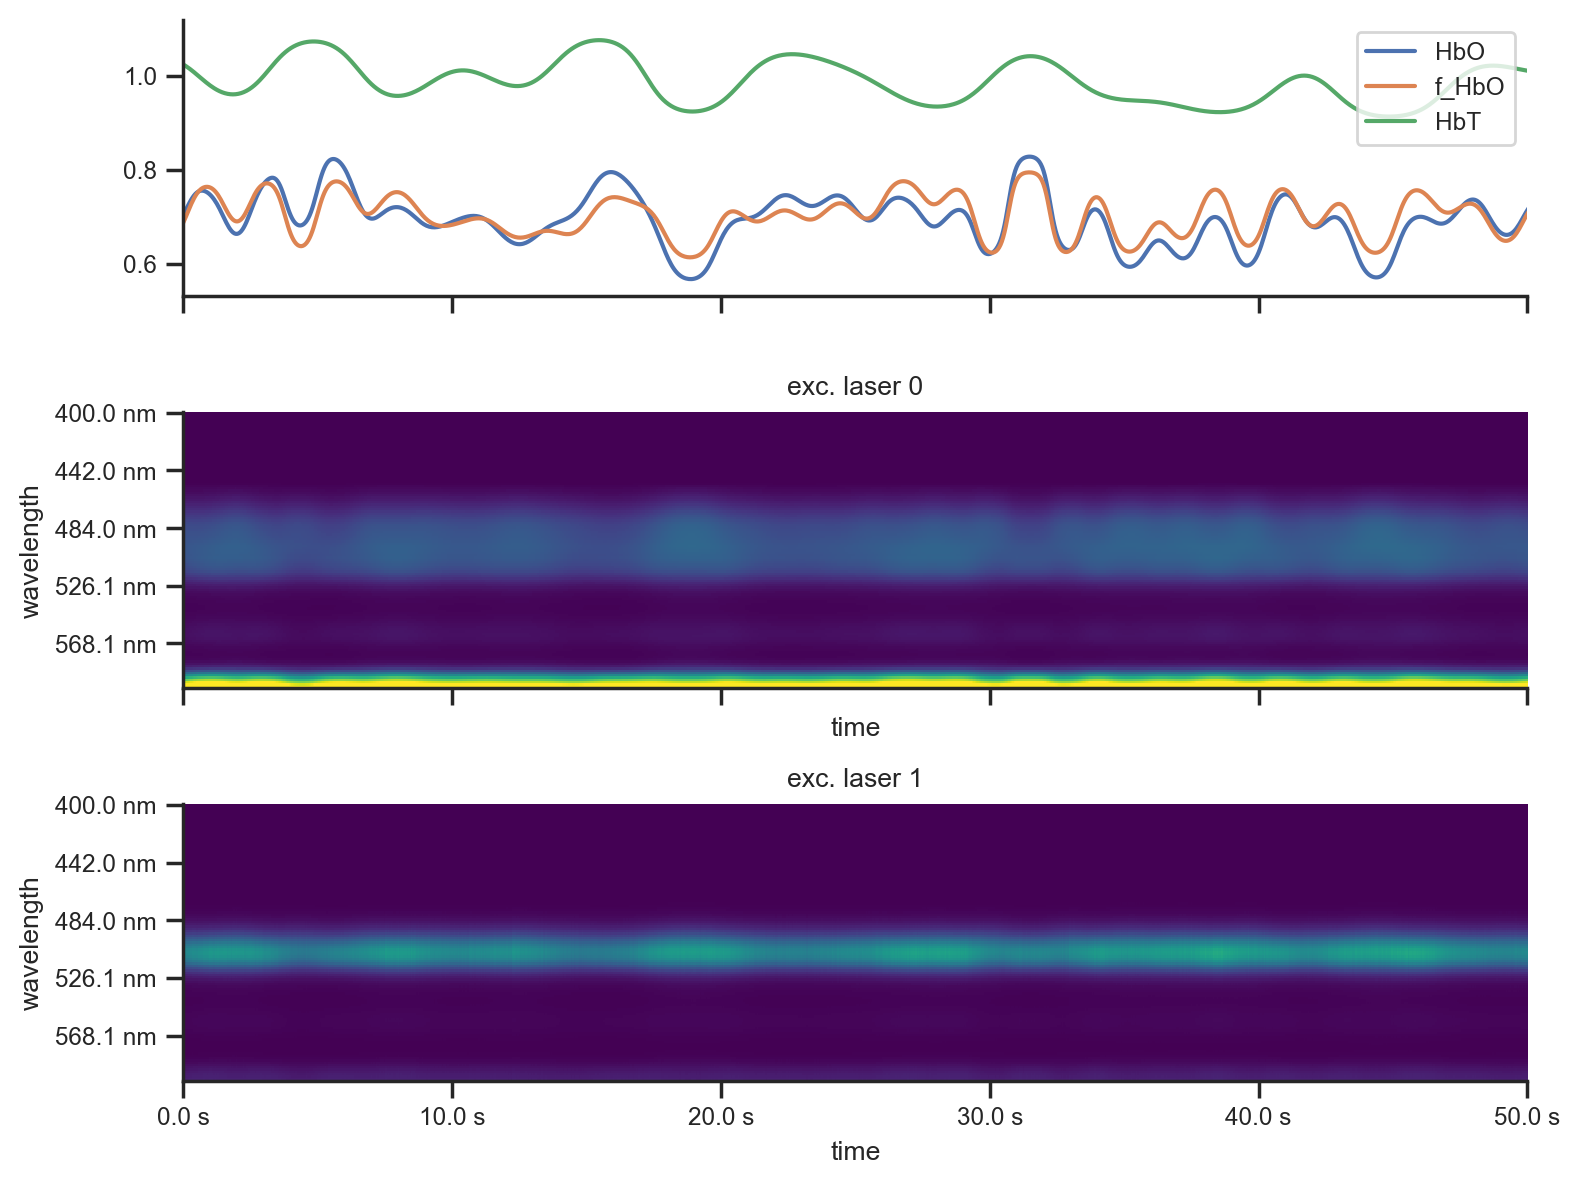

In [24]:
# C_HbT and C_HbO are in normalized units.
# C_HbT = 1 here is equivalent to 150 g/L of Hemoglobin
# plot
f, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
ax[0].plot(np.arange(0, C_HbO.size), C_HbO, label="HbO")
ax[0].plot(np.arange(0, C_HbT.size), f_HbO, label="f_HbO")
ax[0].plot(np.arange(0, C_HbT.size), C_HbT, label="HbT")

ax[0].legend()
ax[1].imshow(H.T, aspect="auto", cmap="viridis", vmin=0.0, vmax=0.4, interpolation="nearest")
ax[1].xaxis.set(major_formatter=fmt_x)
ax[1].yaxis.set(major_formatter=fmt_y)
ax[1].set(xlim=(0, 1000), ylabel="wavelength", xlabel="time", title="exc. laser 0")

ax[2].imshow(fSWPH[:, 1, :].T, aspect="auto", cmap="viridis", vmin=0.0, vmax=0.05, interpolation="nearest")
ax[2].xaxis.set(major_formatter=fmt_x)
ax[2].yaxis.set(major_formatter=fmt_y)
ax[2].set(xlim=(0, 1000), ylabel="wavelength", xlabel="time", title="exc. laser 1")
plt.tight_layout()
plt.show()

In [25]:
S_autofl = sim.get_S_autofl()
W_autofl = sim.get_W_autofl()
f_autofl = sim.gen_autofl()

print(f"f_autofl: {f_autofl.shape}")
print(f"S_autofl: {S_autofl.shape}")
print(f"W_autofl: {W_autofl.shape}")

f_autofl: (72000, 2)
S_autofl: (2, 120)
W_autofl: (2, 5)


In [26]:
fSW_autofl = np.einsum("ti,il,ij->tjl", f_autofl, S_autofl, W_autofl)
fSWP_autofl = np.einsum("tjl,tj->tjl", fSW_autofl, P)
fSWPH_autofl = np.einsum("tjl,tl->tjl", fSWP_autofl, H)

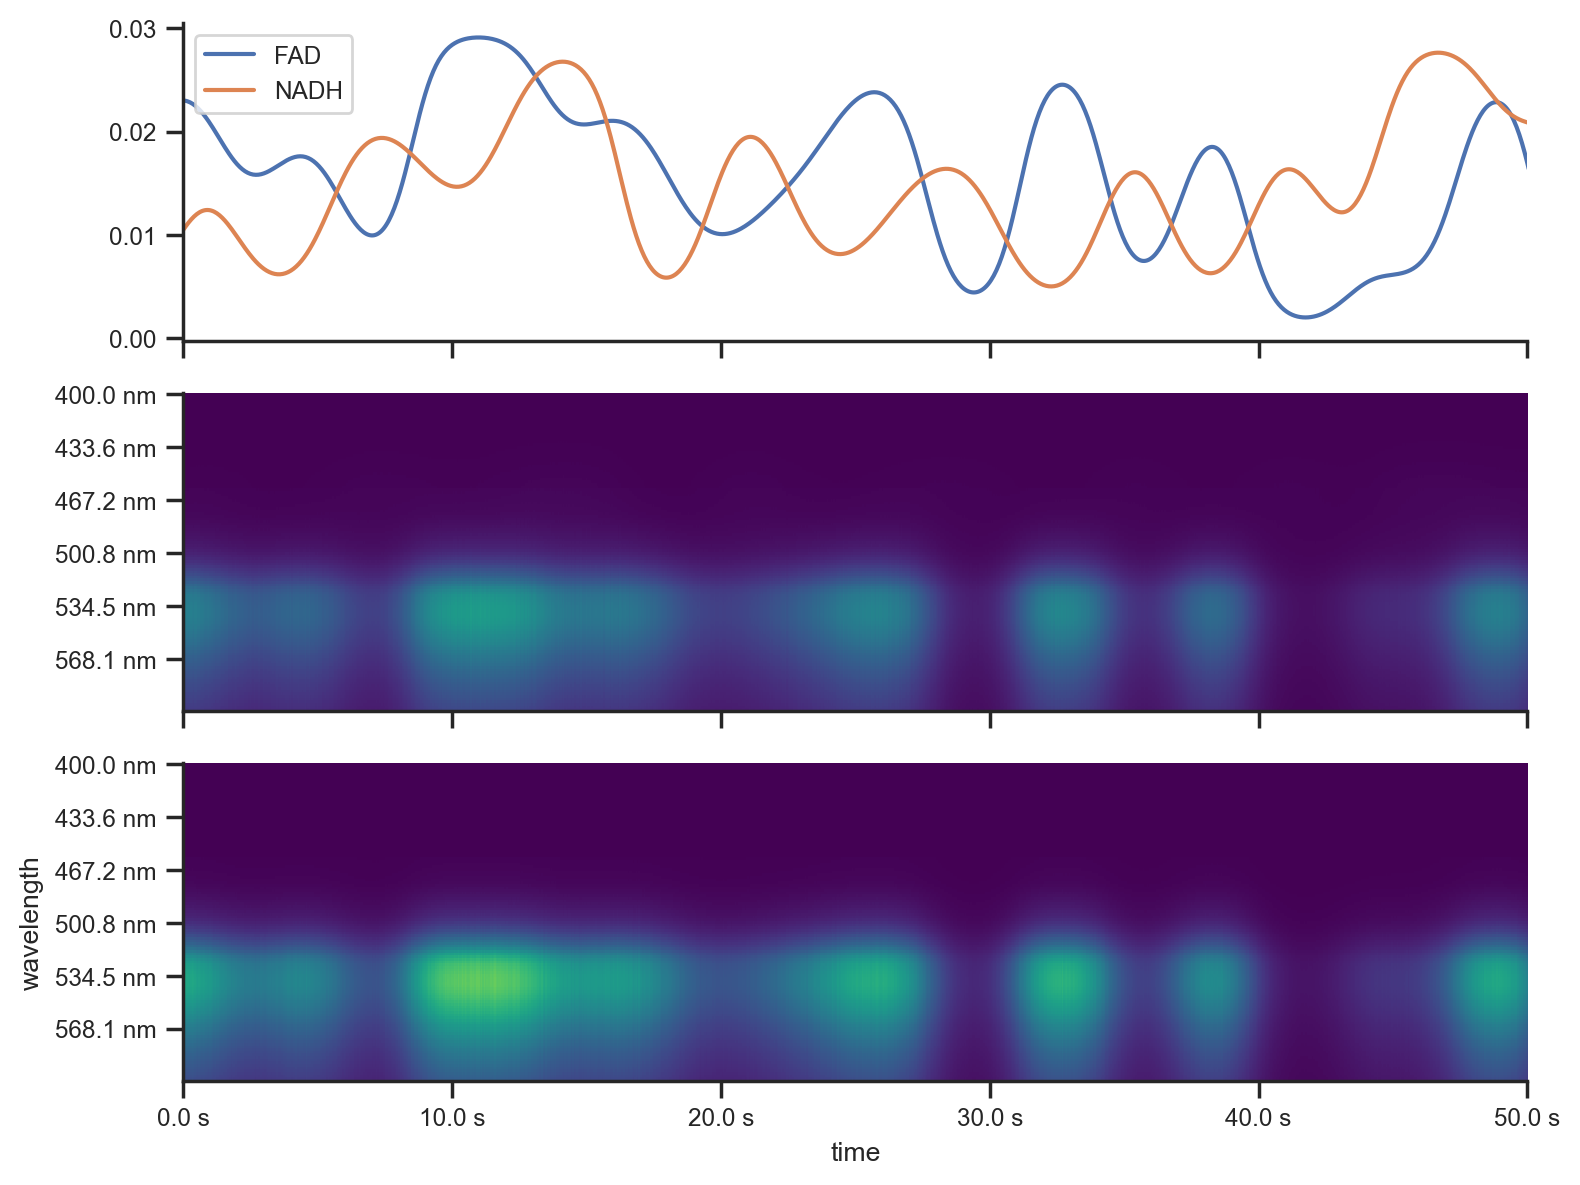

In [27]:
# Autofluorescence
f, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
ax[0].plot(np.arange(0, f_autofl.shape[0]), f_autofl[:, 0], label=list(sim.cfg["autofl"].keys())[0])
ax[0].plot(np.arange(0, f_autofl.shape[0]), f_autofl[:, 1], label=list(sim.cfg["autofl"].keys())[1])

ax[0].legend()
ax[1].imshow(fSWP_autofl[:, 0, :].T, aspect="auto", cmap="viridis", vmin=0.0, vmax=0.03, interpolation="nearest")
ax[1].xaxis.set(major_formatter=fmt_x)
ax[1].yaxis.set(major_formatter=fmt_y)

ax[2].imshow(fSWP_autofl[:, 1, :].T, aspect="auto", cmap="viridis", vmin=0.0, vmax=0.03, interpolation="nearest")
ax[2].xaxis.set(major_formatter=fmt_x)
ax[2].yaxis.set(major_formatter=fmt_y)
ax[2].set(xlim=(0, 1000), ylabel="wavelength", xlabel="time")
plt.tight_layout()
plt.show()

In [28]:
O = fSWPH_autofl + fSWPH

In [29]:
# for one observation wavelength:
from aind_ophys_utils.dff import dff

lam_ = 520

F_ = np.squeeze(fSWP[:, 1, sim.get_L_ind(lam_)])
F_autfl_ = np.squeeze(fSWP_autofl[:, 1, sim.get_L_ind(lam_)])
FH_ = np.squeeze(fSWPH[:, 1, sim.get_L_ind(lam_)])
FH_autfl_ = np.squeeze(fSWPH_autofl[:, 1, sim.get_L_ind(lam_)])
baseline_ = np.squeeze(F0SWP[:, 1, sim.get_L_ind(lam_)])
baselineH_ = np.squeeze(F0SWPH[:, 1, sim.get_L_ind(lam_)])


dff_signal, dff_baseline_, _ = dff(
    FH_ + FH_autfl_, fs=sim.cfg["sensor"]["sampling_freq_Hz"], long_window=20.0, short_window=2.0, inactive_percentile=2
)

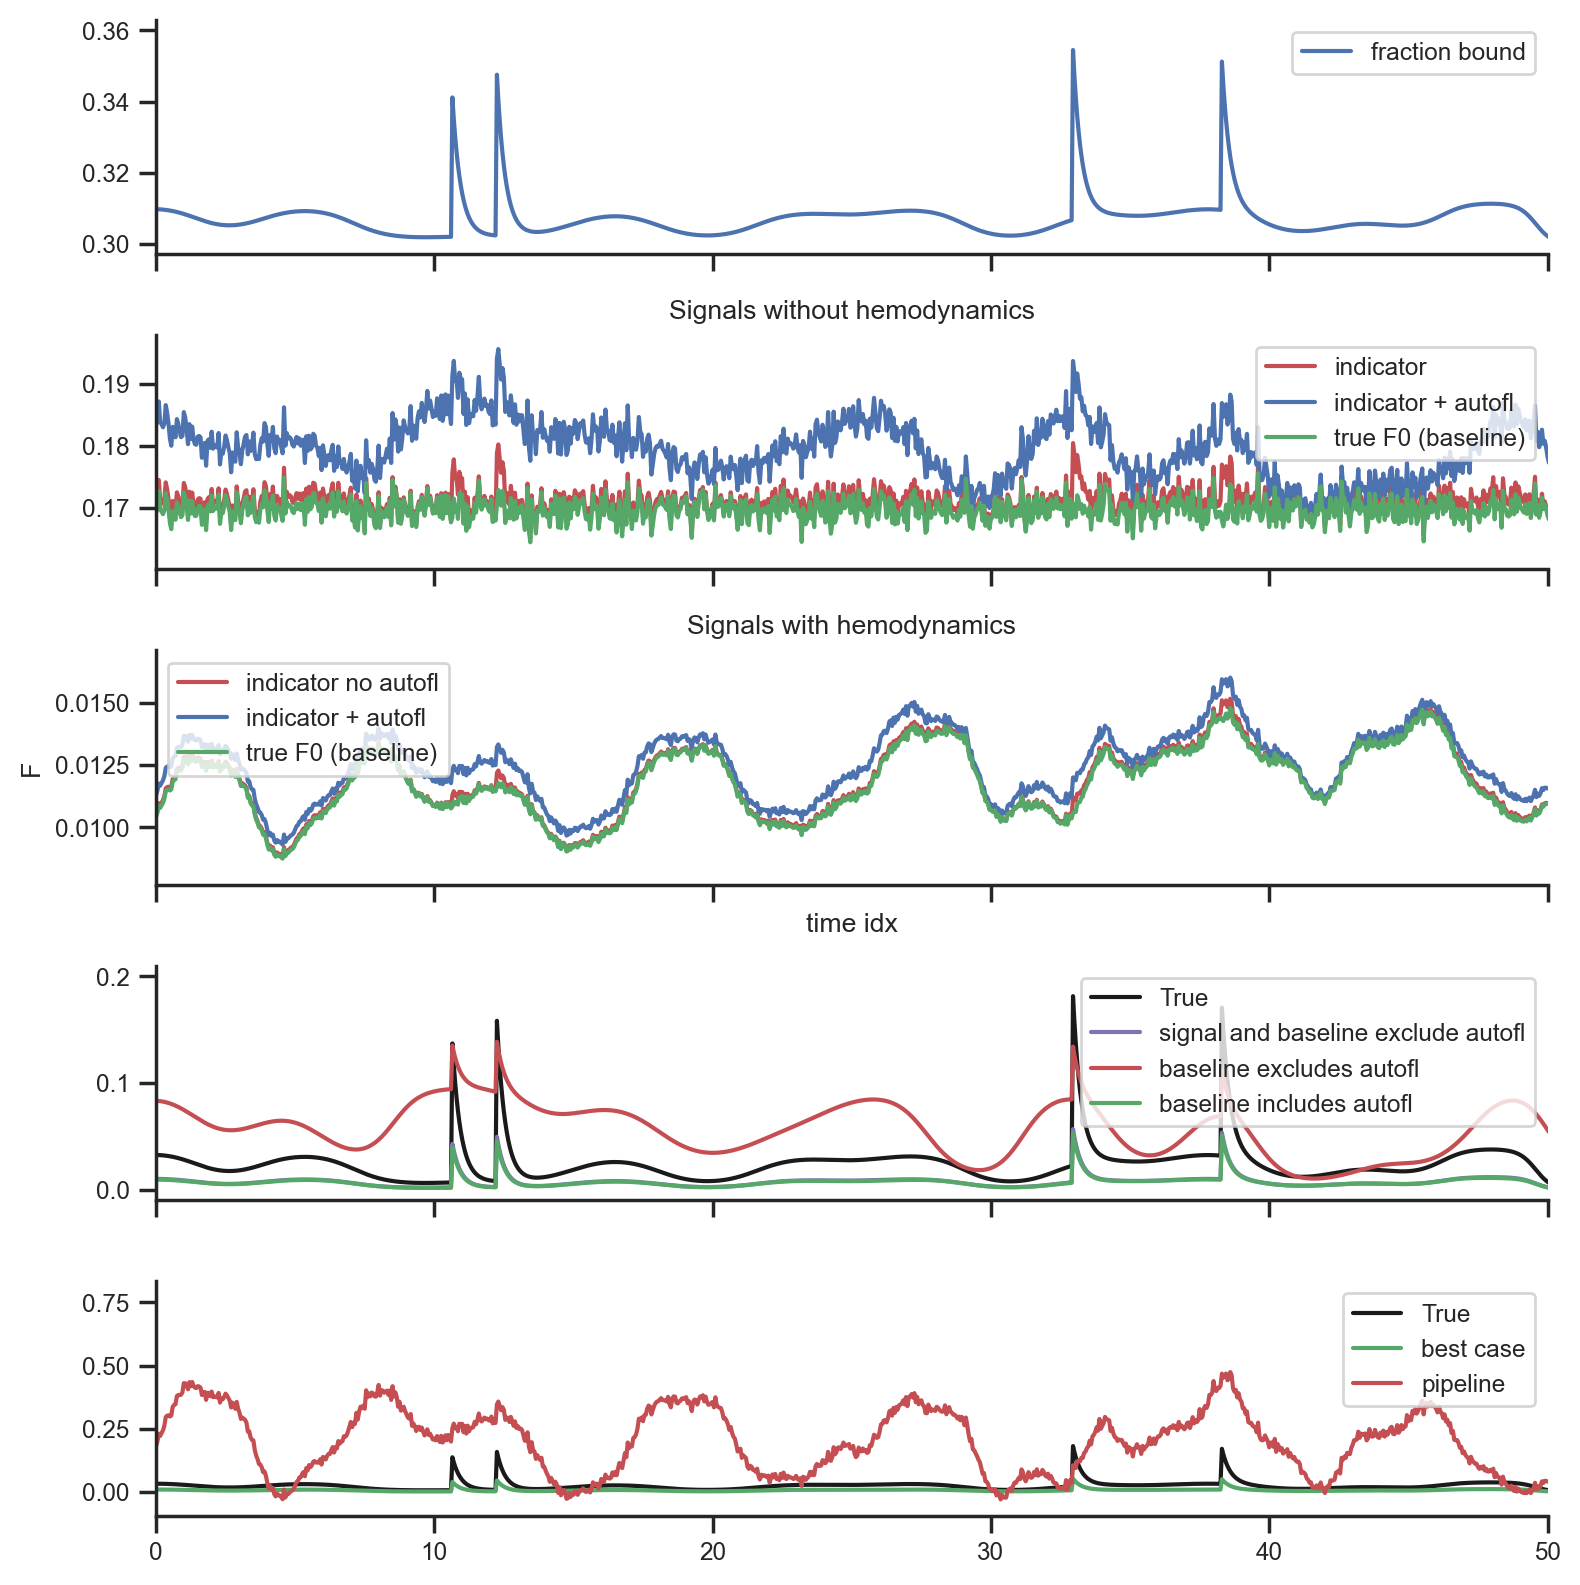

In [30]:
f, ax = plt.subplots(5, 1, figsize=(8, 8), sharex=True)
ax[0].plot(sim.T_arr, fb, label="fraction bound")
ax[0].legend()

ax[1].plot(sim.T_arr, F_, "r", label="indicator")
ax[1].plot(sim.T_arr, F_ + F_autfl_, "b", label="indicator + autofl")
ax[1].plot(sim.T_arr, baseline_, "g", label="true F0 (baseline)")
ax[1].set(title="Signals without hemodynamics")
ax[1].legend()

ax[2].plot(sim.T_arr, FH_, "r", label="indicator no autofl")
ax[2].plot(sim.T_arr, FH_ + FH_autfl_, "b", label="indicator + autofl")
ax[2].plot(sim.T_arr, baselineH_, "g", label="true F0 (baseline)")
ax[2].set(xlim=(0, sim.T_arr[1000]), ylabel="F", xlabel="time idx")
ax[2].set(title="Signals with hemodynamics")
ax[2].legend()

ax[3].plot(sim.T_arr, (fb - f_rest) / f_rest, "k", label="True")
ax[3].plot(sim.T_arr, (FH_ - baselineH_) / baselineH_, "m", label="signal and baseline exclude autofl")
ax[3].plot(sim.T_arr, (FH_ + FH_autfl_ - baselineH_) / baselineH_, "r", label="baseline excludes autofl")
ax[3].plot(
    sim.T_arr,
    (FH_ + FH_autfl_ - baselineH_ - FH_autfl_) / (baselineH_ + FH_autfl_),
    "g",
    label="baseline includes autofl",
)
ax[3].legend()

ax[4].plot(sim.T_arr, (fb - f_rest) / f_rest, "k", label="True")
ax[4].plot(sim.T_arr, (FH_ + FH_autfl_ - baselineH_ - FH_autfl_) / (baselineH_ + FH_autfl_), "g", label="best case")
ax[4].plot(sim.T_arr, dff_signal, "r", label="pipeline")
ax[4].legend()

plt.legend()
plt.tight_layout()
plt.show()

# in this case, (FH_-baselineH_)/baselineH_ is not too different from (FH_+FH_autfl_-baselineH_-FH_autfl_)/(baselineH_+FH_autfl_);
# both of the above are close to a scalar multiple of (fb-f_rest)/f_rest
# pipeline run with typical dff parameters is dominated by hemodynamic signal.

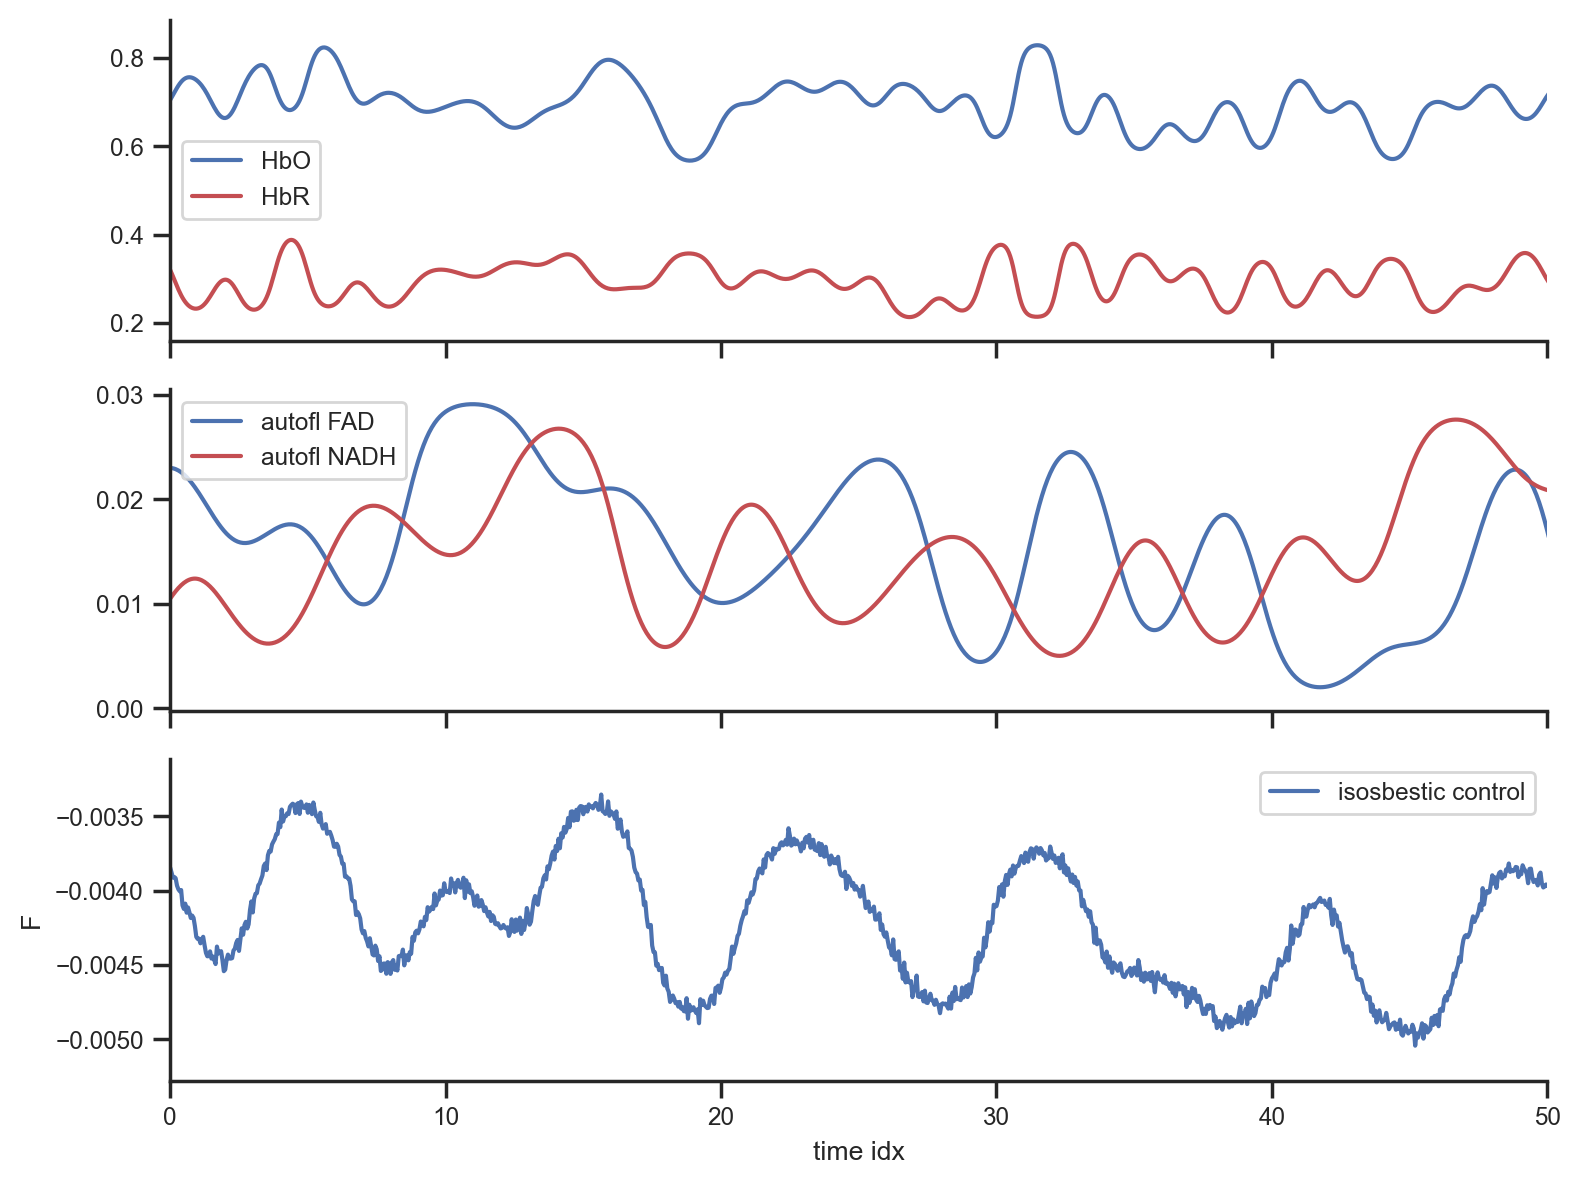

In [31]:
# Compare isosbestic control (which does not include any correction for hemodynamics)

lam_0 = 500
lam_1 = 520

# observed signals at the two wavelengths
F0 = np.squeeze(fSWP[:, 0, sim.get_L_ind(lam_0)])
F1 = np.squeeze(fSWP[:, 1, sim.get_L_ind(lam_1)])

# constants to be used for the linear combination
m = Sf[0, sim.get_L_ind(lam_1)] * np.mean(P[:, 1]) * (Wf[0, 1] - Wb[0, 1])
n = Sf[0, sim.get_L_ind(lam_0)] * np.mean(P[:, 0]) * (Wb[0, 0] - Wf[0, 0])

# The signal independent of bound fraction
F_iso = m * F0 + n * F1

# observed signals at the two wavelengths
F0 = np.squeeze(fSWPH[:, 0, sim.get_L_ind(lam_0)])
F1 = np.squeeze(fSWPH[:, 1, sim.get_L_ind(lam_1)])

# constants to be used for the linear combination
m = Sf[0, get_lind(lam_1)] * np.mean(P[:, 1]) * (Wf[0, 1] - Wb[0, 1])
n = Sf[0, get_lind(lam_0)] * np.mean(P[:, 0]) * (Wb[0, 0] - Wf[0, 0])

# The signal independent of indicator bound fraction is a source for the isosbestic control
FH_iso = m * F0 + n * F1

f, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
ax[0].plot(sim.T_arr, C_HbO, c="b", label="HbO")
ax[0].plot(sim.T_arr, C_HbR, c="r", label="HbR")
ax[1].plot(sim.T_arr, f_autofl[:, 0], c="b", label="autofl FAD")
ax[1].plot(sim.T_arr, f_autofl[:, 1], c="r", label="autofl NADH")
ax[2].plot(sim.T_arr, FH_iso, "b", label="isosbestic control")
ax[2].set(xlim=(0, sim.T_arr[1000]), ylabel="F", xlabel="time idx")
for a in ax:
    a.legend()
plt.tight_layout()
plt.show()

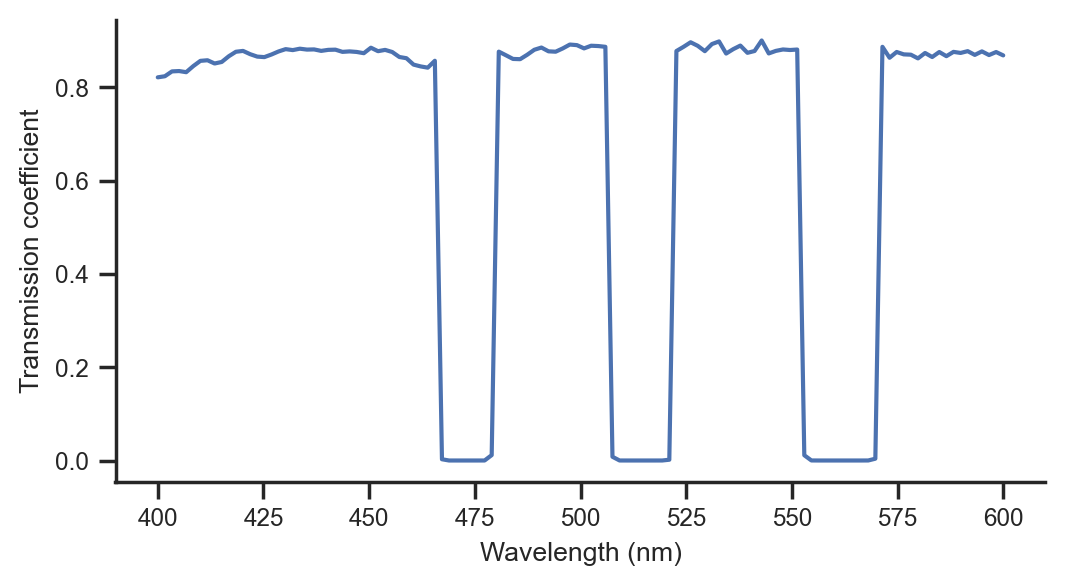

In [32]:
notches = sim.get_notches()

f, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(sim.L_arr, notches)
ax.set(xlabel="Wavelength (nm)", ylabel="Transmission coefficient")
plt.show()

In [33]:
O = np.einsum("tjl,l->tjl", fSWPH + fSWPH_autofl, notches)

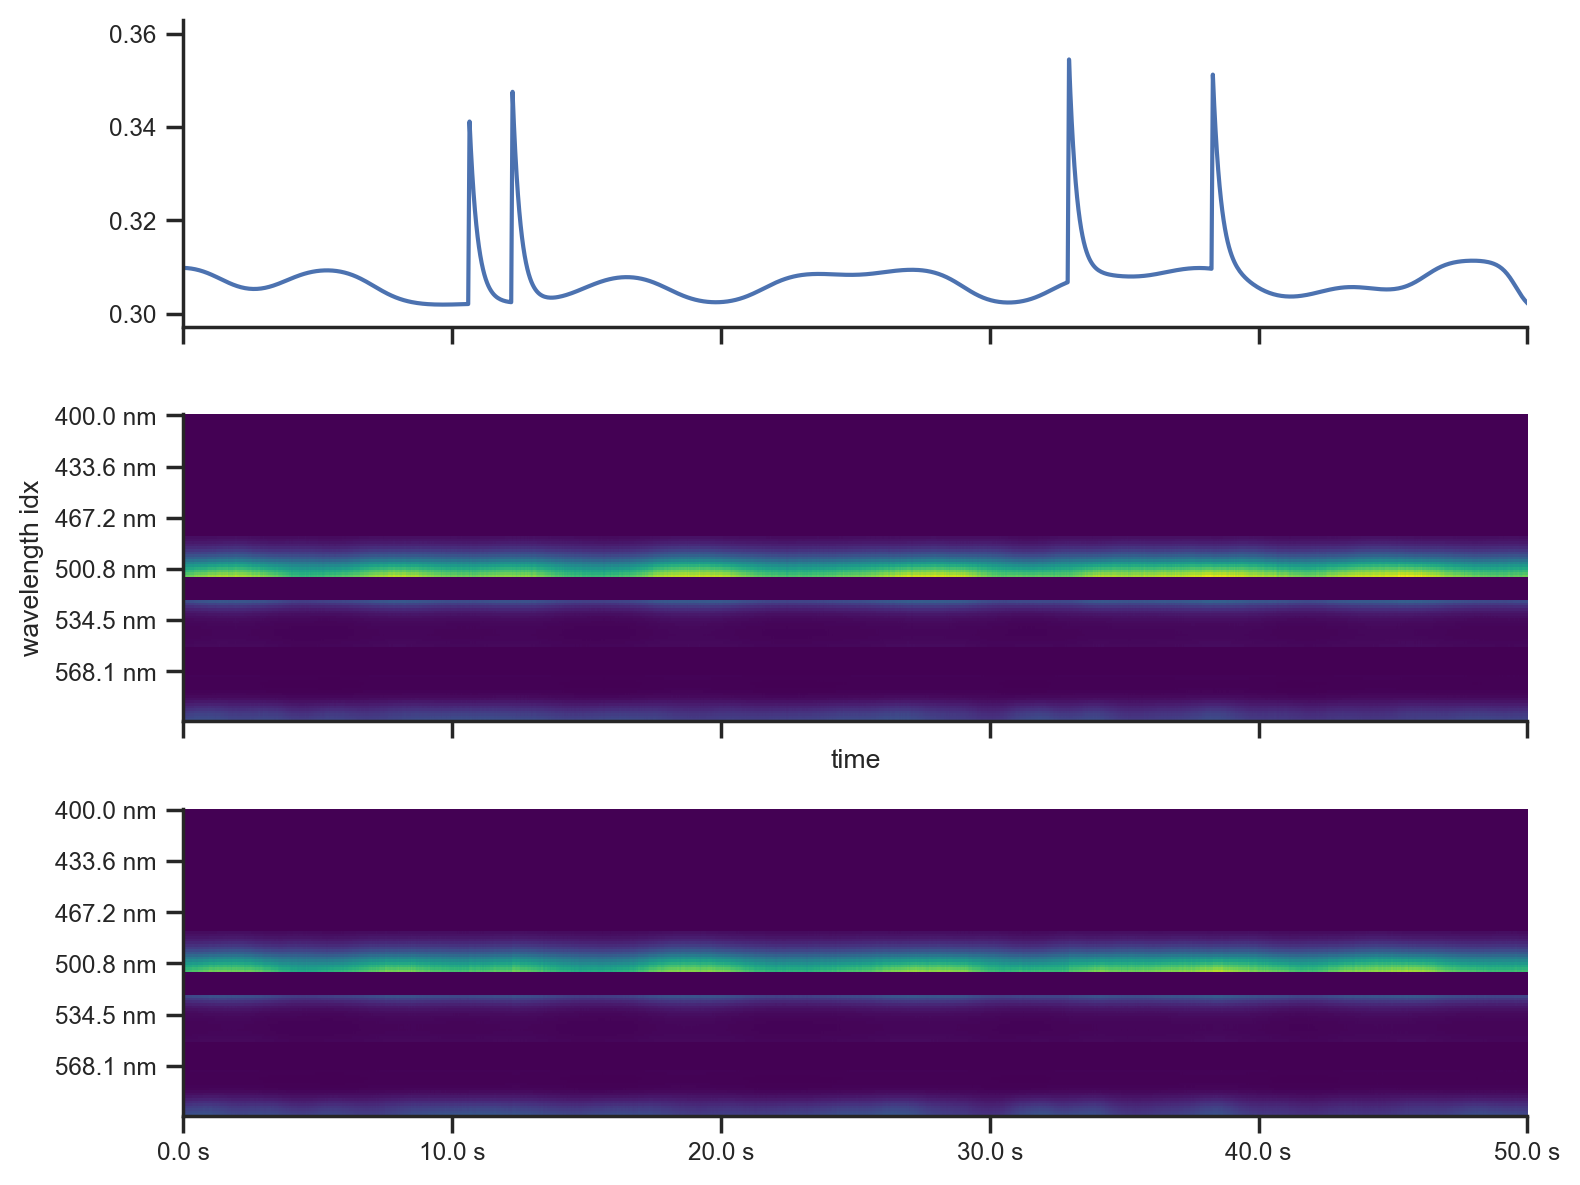

In [34]:
f, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
ax[0].plot(np.arange(0, fb.size), fb)
ax[1].imshow(O[:, 0, :].T, aspect="auto", cmap="viridis", vmin=0.0, vmax=0.03, interpolation="nearest")
ax[1].xaxis.set(major_formatter=fmt_x)
ax[1].yaxis.set(major_formatter=fmt_y)
ax[2].imshow(O[:, 1, :].T, aspect="auto", cmap="viridis", vmin=0.0, vmax=0.03, interpolation="nearest")
ax[2].xaxis.set(major_formatter=fmt_x)
ax[2].yaxis.set(major_formatter=fmt_y)
ax[1].set(xlim=(0, 1000), ylabel="wavelength idx", xlabel="time")
plt.tight_layout()
plt.show()

In [35]:
# Next steps:

# Include bleaching
# As a function of hemodynamics parameters:

# run pipeline with true df/f
# run pipeline with approx df/f
# run pipeline with ophys pipeline df/f

# applying the naïve pipeline meant for Ca imaging to fiber photometry data
# add autofluoresence
# get ground truth baseline F0 out (accounts for f_rest and autofluoresence)